# WeatherPy

### Trends Noticed in Weather Data

* As expected, temperature does move from cold to warm and back to cold again as you move from south pole to equator to north pole, but center of this inverted parabola is not the equator.  It is around 30 degrees north latitude.  I am not sure if this is because it is summer in northern hemisphere or some kind of artifact of there being much more habitable land and cities in northern hemisphere. Repeating this exercise throughout the year would reveal if this is seasonal or not.


* There is a noticeable trend related to equator for humidity.  A narrow band at the equator has consistently high humnidity.  But even a few degrees away from equator and humidty becomes much more random, with low and high humidity values found at nearly every other latitude.


* I can see no trends for cloud cover or wind speed.  Both appear to be localized, not tied to latitude.

In [21]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
from pprint import pprint
import os

# Import API key
from api_keys import api_key

# Incorporated citipy to determine city based on latitude and longitude
from citipy import citipy

# Range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)

## Generate Cities List

In [22]:
# function to pull cities using citpy
# should only be run once. right to input csv and pull from that afterwards
def generate_city_list_csv(city_output_csv):    
    # Lists for holding city info
    lat_lngs = []
    cities = []
    countries = []
    latitudes = []
    longitudes = []
    weather_urls = []
    
    # set up base url with key and imperial units
    weather_base_url = "http://api.openweathermap.org/data/2.5/weather?appid=" + api_key + "&units=imperial"

    # Create a set of random lat and lng combinations
    lats = np.random.uniform(low=-90.000, high=90.000, size=1500)
    lngs = np.random.uniform(low=-180.000, high=180.000, size=1500)
    lat_lngs = zip(lats, lngs)

    # Identify nearest city for each lat, lng combination
    for lat_lng in lat_lngs:
        city = citipy.nearest_city(lat_lng[0], lat_lng[1]).city_name
        
        # add city name to base URL. makes it easier to call api during that step
        weather_url = weather_base_url + "&q=" + city
        
        city_country = citipy.nearest_city(lat_lng[0], lat_lng[1]).country_code
        city_lat = lat_lng[0]
        city_lng = lat_lng[1]
    
        # If the city is unique, then add it to a our cities list
        if city not in cities:
            cities.append(city)
            countries.append(city_country.upper())
            latitudes.append(city_lat)
            longitudes.append(city_lng)
            weather_urls.append(weather_url)

    # zip all my city lists together
    city_country_coord_url = zip(cities, countries, latitudes, longitudes, weather_urls)

    # turn zipped lists into a dataframe
    cities_df = pd.DataFrame(city_country_coord_url, columns=["City", "Country Code", "Latitude", "Longitude", "URL"])

    # I found a csv on web of the 2-character ISO codes for each country.
    # I used this to add full country name to my dataset
    country_xref_csv = os.path.join("Resources", "country_code_2char.csv")

    # read in file of country codes and country names
    country_xref_df = pd.read_csv(country_xref_csv)
    country_xref_df = country_xref_df.rename(columns={"Code": "Country Code"})

    # merge cross reference dataframe with my main dataframe, on country code
    city_country_df = pd.merge(cities_df, country_xref_df, on="Country Code")

    # write all city data to requested file
    city_country_df.to_csv(city_output_csv, index=False)
    
    return city_country_df

In [23]:
my_city_csv = os.path.join("Resources", "Cities_Dataset.csv")

# See function above for how I got my set of cities
# I just wanted a static set of cities, not different cities every run
#my_city_df = generate_city_list_csv(my_city_csv)

# with set of cities already generated, just read from that csv
my_city_df = pd.read_csv(my_city_csv)

print(my_city_df["City"].count())
my_city_df.head()

607


,City,Country Code,Latitude,Longitude,URL,Name
0,yellowknife,CA,68.627134,-110.403570,http://api.openweathermap.org/data/2.5/weather...,Canada
1,attawapiskat,CA,60.330174,-84.592010,http://api.openweathermap.org/data/2.5/weather...,Canada
2,torbay,CA,47.265836,-45.794116,http://api.openweathermap.org/data/2.5/weather...,Canada
3,the pas,CA,53.706701,-100.064596,http://api.openweathermap.org/data/2.5/weather...,Canada
4,iqaluit,CA,62.723228,-73.039239,http://api.openweathermap.org/data/2.5/weather...,Canada


### Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it'sbeing processed (with the city number and city name).


In [24]:
# function to call Open Weather API for each city
# Should only run once and write API returned info to a csv
# pull data from csv after that
def get_weather_data(city_input_df, weather_data_csv, api_call_log):
    city_temps = []
    city_humidities = []
    city_clouds = []
    city_winds = []
    city_dates = []
    city_latitudes = []
    city_longitudes = []
    
    # open a log file to trace all our API calls for each city
    with open(api_call_log, "w") as log_file:
        log_file.write(f"Weather API Call Log\n")
        log_file.write(f"--------------------\n")
        
        # iterate through each city in our dataframe
        for index, row in city_input_df.iterrows():            
            query_url = row["URL"]
            
            log_file.write(f"Calling Open Weather API:\n")
            log_file.write(f"    Iteration: {index}\n")
            log_file.write(f"    City: {row['City']}\n")
            log_file.write(f"    URL: {row['URL']}\n")
        
            weather_data = requests.get(query_url).json()
        
            # city may not be found, so use "try" to extract data
            try:
                city_temp = weather_data["main"]["temp_max"]
                city_temps.append(city_temp)
        
                city_humidity = weather_data["main"]["humidity"]
                city_humidities.append(city_humidity)
        
                city_cloud = weather_data["clouds"]["all"]
                city_clouds.append(city_cloud)
        
                city_wind = weather_data["wind"]["speed"]
                city_winds.append(city_wind)
            
                city_date = weather_data["dt"]
                city_dates.append(city_date)
                           
                # get actual latitude/longitude of city from Open Weather
                # our values from citipy were "closest", but could be very far away,
                # if we randomly chose a spot in middle of ocean or desert or tundra or something                
                city_latitude = weather_data["coord"]["lat"]
                city_latitudes.append(city_latitude)
                
                city_longitude = weather_data["coord"]["lon"]
                city_longitudes.append(city_longitude)
                
                log_file.write(f"    Data retrieved {city_temp} {city_humidity} {city_cloud} {city_wind} {city_date}\n")
            except KeyError:
                # Data was missing from API return, so just set weather values to None
                city_temp = None
                city_temps.append(city_temp)
        
                city_humidity = None
                city_humidities.append(city_humidity)
        
                city_cloud = None
                city_clouds.append(city_cloud)
        
                city_wind = None
                city_winds.append(city_wind)
            
                city_date = None
                city_dates.append(city_date)
                           
                city_latitude = None
                city_latitudes.append(city_latitude)
                
                city_longitude = None
                city_longitudes.append(city_longitude)
                           
                log_file.write(f"    City weather data not found\n")

        # close log file
        log_file.close()

    # populate dataframe with info we received from Open Weather API
    city_input_df["Max Temperature"] = city_temps
    city_input_df["Humidity"] = city_humidities
    city_input_df["Cloud Cover"] = city_clouds
    city_input_df["Wind Speed"] = city_winds
    city_input_df["Date"] = city_dates
    city_input_df["Latitude"] = city_latitudes
    city_input_df["Longitude"] = city_longitudes

    # write dataframe to csv
    city_input_df.to_csv(weather_data_csv, index=False)

    return city_input_df

In [25]:
my_city_weather_snapshot_csv = os.path.join("Resources", "City_Weather_Data_Snapshot.csv")
my_city_weather_log_file = os.path.join("Resources", "Weather_API_Call_Log.txt")

# See function above for how I pulled data from OpenWeather API
# I just dumped to a csv after retrieving.  This is now commented out.
# I want consistent data while working with matplotlib
#my_city_weather_df = get_weather_data(my_city_df, my_city_weather_snapshot_csv, my_city_weather_log_file)

# Just read in weather data previously exported
my_city_weather_df = pd.read_csv(my_city_weather_snapshot_csv)

# Drop URL column. Don't need anymore and it makes output harder to read
my_city_weather_df = my_city_weather_df.drop(columns=["URL"])

# Drop cities where Open Weather had no data.
my_city_weather_df = my_city_weather_df.dropna()
my_city_weather_df = my_city_weather_df.reset_index(drop=True)

# Convert Date from Epoch to m/d/y
mdy_date = time.strftime('%m/%d/%Y %H:%M', time.localtime(my_city_weather_df["Date"][0]))
my_city_weather_df["Date"] = mdy_date

# Make sure our final dataframe has sufficient number of cities
my_city_weather_df["City"].count()

561

In [26]:
# display part of dataframe to confirm data looks good
my_city_weather_df.head()

,City,Country Code,Latitude,Longitude,Name,Max Temperature,Humidity,Cloud Cover,Wind Speed,Date
0,yellowknife,CA,62.45,-114.38,Canada,66.20,63.0,75.0,12.75,06/26/2019 15:31
1,torbay,CA,47.66,-52.73,Canada,62.01,62.0,20.0,10.29,06/26/2019 15:31
2,the pas,CA,53.82,-101.24,Canada,68.00,56.0,90.0,9.17,06/26/2019 15:31
3,iqaluit,CA,63.75,-68.52,Canada,44.60,75.0,20.0,6.93,06/26/2019 15:31
4,tuktoyaktuk,CA,69.44,-133.03,Canada,39.20,80.0,90.0,14.99,06/26/2019 15:31


### Plotting the Data
* Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

#### Latitude vs. Temperature Plot

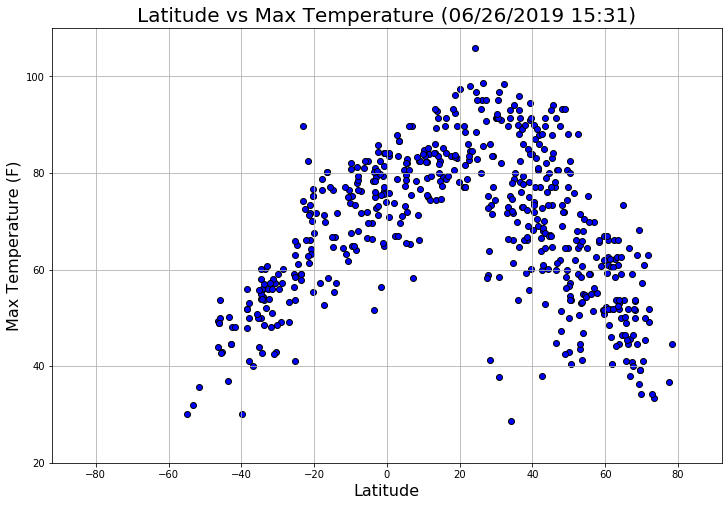

In [27]:
# set size of graph
plt.figure(figsize=(12, 8))

# make max temperature plot
temp_plot = plt.scatter(
    my_city_weather_df["Latitude"], my_city_weather_df["Max Temperature"],
    marker = "o", facecolor="blue", edgecolor="black")

# set labels and graph features
plt.title(f"Latitude vs Max Temperature ({my_city_weather_df['Date'][0]})", fontsize=20)

plt.xlim(-92, 92)
plt.xticks(np.arange(-80, 81, 20))
plt.xlabel("Latitude", fontsize=16)

plt.ylim(20, 110)
plt.yticks(np.arange(20, 110, 20))
plt.ylabel("Max Temperature (F)", fontsize=16)

plt.grid()

# save graph image
save_temp = os.path.join("images", "Latitude_Temp_Chart")
plt.savefig(save_temp, bbox_inches="tight")

plt.show()

#### Latitude vs. Humidity Plot

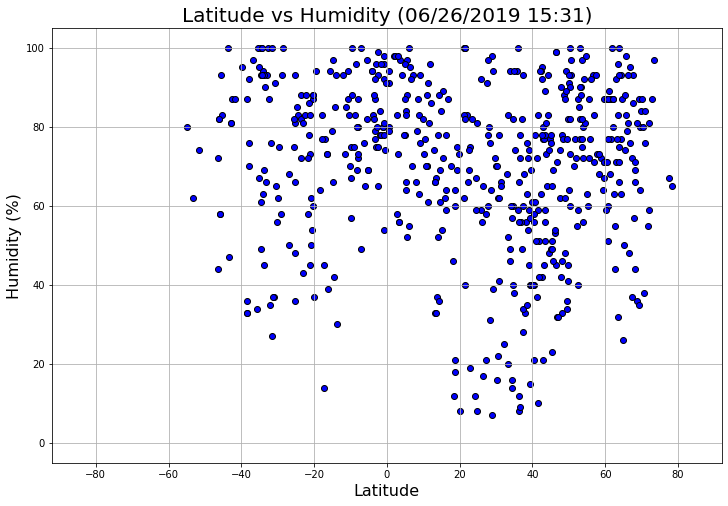

In [28]:
# set size of graph
plt.figure(figsize=(12, 8))

# create humidiuty plot
humid_plot = plt.scatter(
    my_city_weather_df["Latitude"], my_city_weather_df["Humidity"],
    marker = "o", facecolor="blue", edgecolor="black")

# set labels and graph features
plt.title(f"Latitude vs Humidity ({my_city_weather_df['Date'][0]})", fontsize=20)

plt.xlim(-92, 92)
plt.xticks(np.arange(-80, 81, 20))
plt.xlabel("Latitude", fontsize=16)

plt.ylim(-5, 105)
plt.yticks(np.arange(0, 101, 20))
plt.ylabel("Humidity (%)", fontsize=16)

plt.grid()

# save graph image
save_humid = os.path.join("images", "Latitude_Humidity_Chart")
plt.savefig(save_humid, bbox_inches="tight")

plt.show()

#### Latitude vs. Cloudiness Plot

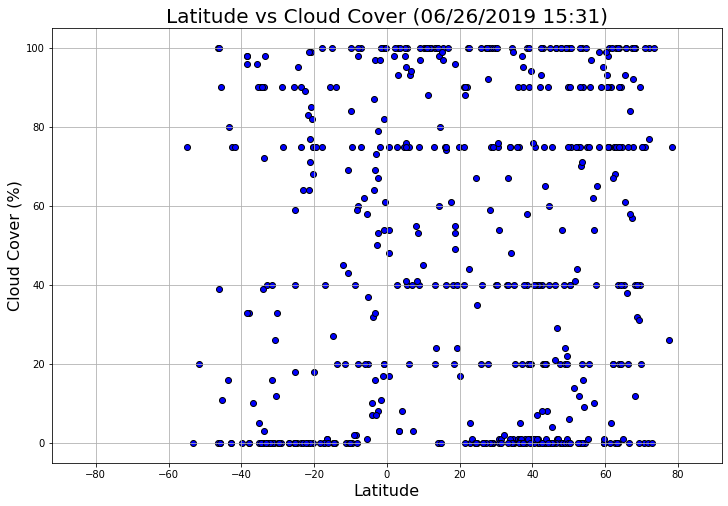

In [29]:
# set graph size
plt.figure(figsize=(12, 8))

# create cloud cover plot
cloud_plot = plt.scatter(
    my_city_weather_df["Latitude"], my_city_weather_df["Cloud Cover"],
    marker = "o", facecolor="blue", edgecolor="black")

# set labels and graph features
plt.title(f"Latitude vs Cloud Cover ({my_city_weather_df['Date'][0]})", fontsize=20)

plt.xlim(-92, 92)
plt.xticks(np.arange(-80, 81, 20))
plt.xlabel("Latitude", fontsize=16)

plt.ylim(-5, 105)
plt.yticks(np.arange(0, 101, 20))
plt.ylabel("Cloud Cover (%)", fontsize=16)

plt.grid()

# save graph image
save_cloud = os.path.join("images", "Latitude_Cloud_Chart")
plt.savefig(save_cloud, bbox_inches="tight")

plt.show()

#### Latitude vs. Wind Speed Plot

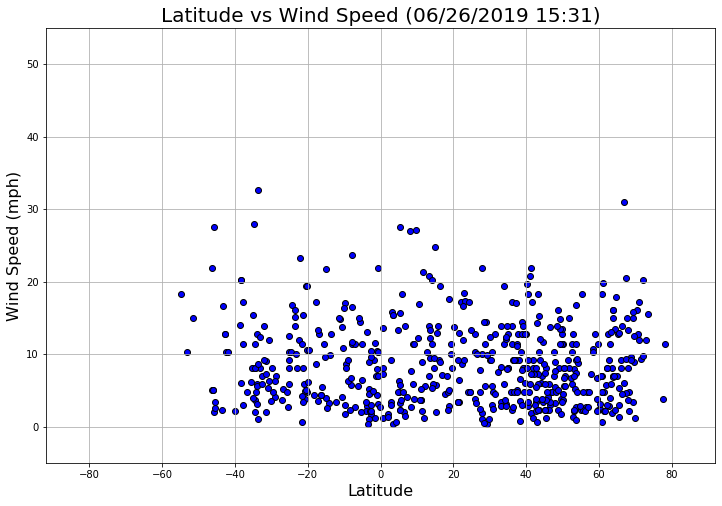

In [30]:
# set graph size
plt.figure(figsize=(12, 8))

# create wind speed plot
wind_plot = plt.scatter(
    my_city_weather_df["Latitude"], my_city_weather_df["Wind Speed"],
    marker = "o", facecolor="blue", edgecolor="black")

# set labels and graph features
plt.title(f"Latitude vs Wind Speed ({my_city_weather_df['Date'][0]})", fontsize=20)

plt.xlim(-92, 92)
plt.xticks(np.arange(-80, 81, 20))
plt.xlabel("Latitude", fontsize=16)

plt.ylim(-5, 55)
plt.yticks(np.arange(0, 51, 10))
plt.ylabel("Wind Speed (mph)", fontsize=16)

plt.grid()

# save graph image
save_wind = os.path.join("images", "Latitude_Wind_Chart")
plt.savefig(save_wind, bbox_inches="tight")

plt.show()